# _bioRxiv_ license choices, before & after the [blog post](http://blog.dhimmel.com/biorxiv-licenses/)

Did the blog post, "[The licensing of _bioRxiv_ preprints](http://blog.dhimmel.com/biorxiv-licenses/)", have an effect on which licensing option authors choose for their _bioRxiv_ preprints? The blog post was published on December 05, 2016.

While the blog post was popular on Twitter, it has only recieved a total of 349 pageviews (as of March 29, 2017). So let's dive into the data.

## Import packages and load data

See notebooks 1 & 2 for how dataset was created. _bioRxiv_ preprint information was obtained from [PrePubMed](http://www.prepubmed.org/)'s data repository.

In [1]:
import os
import json
import math

import pandas
import altair
import vega
from statsmodels.stats.proportion import proportions_ztest

In [2]:
path = os.path.join('data', 'preprints.tsv')
preprint_df = pandas.read_table(path, parse_dates=['Date'])

## Licenses over time (aggregated monthly)

Below we recreate the [first figure](http://blog.dhimmel.com/biorxiv-licenses/#licenses-over-time) from the blog post with the current data (up to March 25, 2017). There appears to be an increase of CC BY licensing near the end of 2016, but it's difficult to tell at this scale.

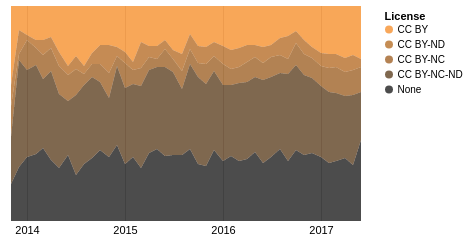

In [3]:
path = os.path.join('figure', 'license-vs-time', 'vega-lite-spec.json')
with open(path) as read_file:
    spec_text = read_file.read()
spec = json.loads(spec_text)
vega.VegaLite(spec, preprint_df)

## Compute weekly license distribution frequencies

In [4]:
# Add a year_week column
ts_to_yearweek = lambda x: '{0}-{1:02d}'.format(*x.isocalendar())
preprint_df['year_week'] = preprint_df.Date.map(ts_to_yearweek)
preprint_df.head(2)

,DOI,Date,License,year_week
0,10.1101/000026,2014-09-08,CC BY,2014-37
1,10.1101/000042,2013-12-01,CC BY,2013-48


In [5]:
# Compute frequencies
weekly_percents = pandas.crosstab(preprint_df.year_week, preprint_df.License, normalize='index')
weekly_percents = weekly_percents.applymap('{:.1%}'.format)
weekly_totals = preprint_df.year_week.value_counts().rename('total')
week_df = weekly_percents.join(weekly_totals).reset_index()
week_df.tail(2)

,year_week,CC BY,CC BY-NC,CC BY-NC-ND,CC BY-ND,None,total
186,2017-22,23.8%,8.5%,32.3%,3.6%,31.8%,223
187,2017-23,20.4%,13.0%,22.2%,7.4%,37.0%,54


In [6]:
# Export as TSV
path = os.path.join('data', 'weeks.tsv')
week_df.to_csv(path, sep='\t', index=False)

## Licenses over time (aggregated weekly)

The blog was released on December 05, 2016, which was the first day of the 49th week of 2016. Below we modify the vega-lite specification to display the weekly-aggregated distributions. As the plot illustrates, there appears to be a slight shift towards more open licenses starting on `2016-49`. 

In [7]:
# Find week of blog post (year, week, day)
blog_ts = pandas.Timestamp('2016-12-05')
blog_ts.isocalendar()

(2016, 49, 1)

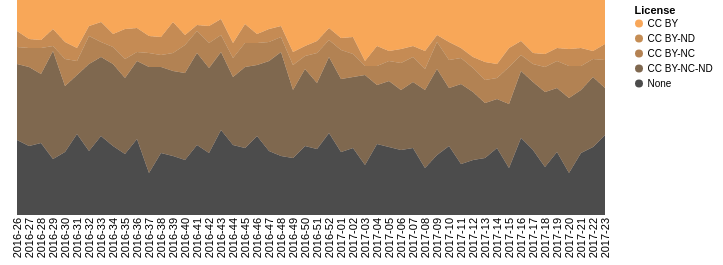

In [8]:
# Modify vega-lite spec to plot weekly distributions
spec = json.loads(spec_text)
del spec['encoding']['x']['timeUnit']
del spec['encoding']['x']['scale']
del spec['encoding']['x']['axis']['format']
del spec['encoding']['x']['axis']['labelAngle']
spec['encoding']['x']['type'] = 'ordinal'
spec['encoding']['x']['field'] = 'year_week'
spec['width'] = 600

# Start midway through 2016
df = preprint_df.query("year_week >= '2016-26'")
vega.VegaLite(spec, df)

## Compare eras: 100 days before and after the blog post

Next, we compare the distribution of licenses for the 100 days preceeding the blog to the 100 days following the blog post.

In [9]:
td = pandas.Timedelta('100 days')
before_df = preprint_df[(preprint_df.Date >= blog_ts - td) & (preprint_df.Date < blog_ts)].copy()
after_df = preprint_df[(preprint_df.Date >= blog_ts) & (preprint_df.Date < blog_ts + td)].copy()
before_df['era'] = 'before'
after_df['era'] = 'after'
era_df = pandas.concat([before_df, after_df])
era_df = pandas.crosstab(era_df.License, era_df.era, margins=True)[['before', 'after', 'All']].reset_index()

# Preprint counts, 100 days before and after
era_df

era,License,before,after,All
0,CC BY,206,434,640
1,CC BY-NC,130,217,347
2,CC BY-NC-ND,589,672,1261
3,CC BY-ND,118,119,237
4,None,458,604,1062
5,All,1501,2046,3547


In [10]:
def prop_test(series):
    """
    Compare proportions after to before.
    """
    count = series.after, series.before
    nobs = era_df.after.iloc[-1], era_df.before.iloc[-1]
    z_score, p_value = proportions_ztest(count, nobs)
    before = count[1] / nobs[1]
    row = {
        'License': series.License,
        'before': '{:.1%}'.format(before),
        'after': '{:.1%}'.format(count[0] / nobs[0]),
        'impact': round(count[0] - before * nobs[0], 2),
        'z_score': round(z_score, 2),
        'p_value': '{:.2e}'.format(p_value),
        'nlog10_p_value': round(-math.log10(p_value), 2),
    }
    return pandas.Series(row)

test_df = (
    era_df
    .iloc[:-1, ]
    .apply(prop_test, axis='columns')
    .sort_values('z_score')
    [['License', 'before', 'after', 'z_score', 'p_value', 'nlog10_p_value', 'impact']]
)

# Results from the comparison of proportions
test_df.sort_values('z_score')

,License,before,after,z_score,p_value,nlog10_p_value,impact
2,CC BY-NC-ND,39.2%,32.8%,-3.93,8.43e-05,4.07,-130.86
3,CC BY-ND,7.9%,5.8%,-2.41,1.60e-02,1.80,-41.84
4,None,30.5%,29.5%,-0.64,5.24e-01,0.28,-20.30
1,CC BY-NC,8.7%,10.6%,1.93,5.40e-02,1.27,39.80
0,CC BY,13.7%,21.2%,5.73,1.01e-08,8.00,153.20


In [11]:
# Bonferroni significance threshold
-math.log10(0.5 / len(test_df))

1.0

### Findings

Licensing options appear to have become more open following the blog post. In the 100 days prior, only 13.7% of preprints were CC BY (the only open license of the bunch). However, over the next 100 days, 21.1% of preprints were CC BY. While the effect size is not huge, the difference is highly significant (_p_ = 1.67 × 10<sup>-8</sup>). Assuming licensing choices would have remained constant absent the blog post, the post resulted in 151 additional CC BY preprints in the 100 days following its release.

The increase in CC BY licensing appears to correspond to a decrease in CC BY-NC-ND licensing, which declined in prevalence from 39.2% to 33.2%. Overall, CC BY and CC BY-NC	increased in prevalence, while CC BY-NC-ND, CC BY-ND, and no license decreased in prevalence. All of these changes were significant at _p_ < 0.01 besides the proportion of unlicensed preprints. Unfortunately, the prevalence of unlicensed preprints remained at ~30%. Unlicensed preprints represent a major concern for the reusability and archivability of the scientific record.


#### Motivations

In the comments for my blog post, I [mentioned](http://blog.dhimmel.com/biorxiv-licenses/#comment-3039042315) that _bioRxiv_ should switch the order of their license selector to display open licenses first. As Jessica Polka [pointed out](http://blog.dhimmel.com/biorxiv-licenses/#comment-3215911237) on March 21, 2017, _bioRxiv_ adopted this suggestion at an unknown date following the blog post:

> It looks like bioRxiv has reversed the order of licenses! Would love to know when this happened and if it has caused any change in license choice.

Thanks Jessica for motivating this analysis! #ASAPBio

#### Limitations

This analysis does not take into account changes to the composition of subjects or authors submitting preprints. Such relative changes could confound this analysis — for example, if preprints gained popularity in more open-minded subject areas relative to close-minded subject areas.